In [133]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt

from utils import init_random_seed, tokenize_corpus, document_vectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
SEED = 1
TRAIN_MODEL = False # if True, then train model and save it. if False, just load it
PATH_MODEL = "./Pre-trained Models/word2vec_xgb_request_category.pkl"
PATH_DATASET = './Data/Dataset_cleaned.csv'

In [ ]:
init_random_seed(SEED)

In [135]:
dataset = pd.read_csv(PATH_DATASET).iloc[:, :2]
dataset.head()

,Request category,Application description
0,Благоустройство территории,На трассе Нижнекамск-Чистополь в лесополосе у ...
1,Благоустройство территории,Во дворе дома Ленинградская 29 отсутствуют пар...
2,Содержание и ремонт муниципальных дорог,Добрый день! Не осуществляется уборка снега в ...
3,Благоустройство территории,Добрый день! Не осуществляется вывоз мусора с ...
4,Содержание и ремонт муниципальных дорог,на данном участке проезжей части от ул.Халитов...


In [136]:
request_category_int = LabelEncoder().fit_transform(dataset['Request category'])
print(f"Unique classes of the variable Request category: {len(dataset['Request category'].unique())}")

Unique classes of the variable Request category: 26


In [137]:
dataset['Application description'] = tokenize_corpus(dataset['Application description'], min_token_size=4)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset['Application description'],
    request_category_int,
    test_size=0.3,
    shuffle=True,
    stratify=request_category_int,
    random_state=SEED
)

X_train.shape, X_test.shape

((17380,), (7449,))

In [139]:
word2vec = Word2Vec(
    sentences=X_train,
    vector_size=50,
    window=5,
    min_count=5,
    sg=1,
    epochs=10,
    seed=SEED
)

In [140]:
X_train = np.array([document_vectorizer(doc, word2vec) for doc in X_train])
X_test = np.array([document_vectorizer(doc, word2vec) for doc in X_test])

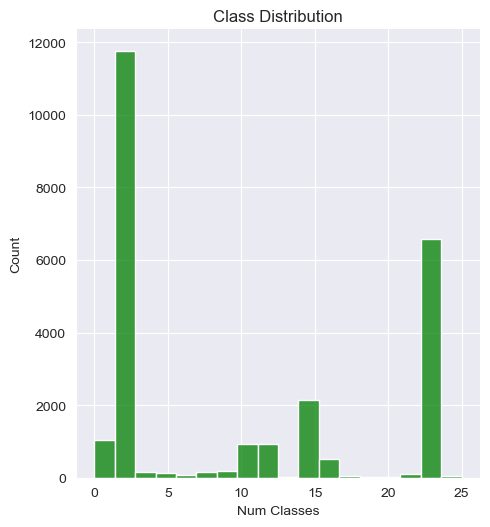

In [141]:
sns.displot(request_category_int, color='green')
plt.xlabel('Num Classes')
plt.title('Class Distribution');

In [142]:
parameters = {
    'objective': 'multi:softprob',
    'learning_rate': 1.0e-1,
    'n_estimators': 1000,
    'early_stopping_rounds': 15,
    'max_depth': 3,
    'subsample': 0.5,
    'eval_metric': ['merror', 'auc'],
    'verbosity': 1,
    'seed': SEED
}

if TRAIN_MODEL:
    xgb_clf = XGBClassifier(**parameters)
    
    xgb_clf.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )

    pickle.dump(xgb_clf, open(PATH_MODEL, "wb"))
else:
    xgb_clf = pickle.load(open(PATH_MODEL, 'rb'))

[0]	validation_0-merror:0.34797	validation_0-auc:0.81349
[1]	validation_0-merror:0.32783	validation_0-auc:0.83811
[2]	validation_0-merror:0.31414	validation_0-auc:0.85117
[3]	validation_0-merror:0.30581	validation_0-auc:0.86011
[4]	validation_0-merror:0.30179	validation_0-auc:0.86578
[5]	validation_0-merror:0.29856	validation_0-auc:0.87026
[6]	validation_0-merror:0.29574	validation_0-auc:0.87358
[7]	validation_0-merror:0.29427	validation_0-auc:0.87655
[8]	validation_0-merror:0.29199	validation_0-auc:0.87867
[9]	validation_0-merror:0.28957	validation_0-auc:0.88056
[10]	validation_0-merror:0.28662	validation_0-auc:0.88258
[11]	validation_0-merror:0.28393	validation_0-auc:0.88443
[12]	validation_0-merror:0.28353	validation_0-auc:0.88593
[13]	validation_0-merror:0.28192	validation_0-auc:0.88708
[14]	validation_0-merror:0.28084	validation_0-auc:0.88811
[15]	validation_0-merror:0.27937	validation_0-auc:0.88915
[16]	validation_0-merror:0.27856	validation_0-auc:0.89000
[17]	validation_0-merror

In [143]:
train_pred_proba = xgb_clf.predict_proba(X_train)
test_pred_proba = xgb_clf.predict_proba(X_test)
test_pred = xgb_clf.predict(X_test)

print(f"AUC Train: {roc_auc_score(y_train, train_pred_proba, multi_class='ovr'):.4f}\n"
      f"AUC Test: {roc_auc_score(y_test, test_pred_proba, multi_class='ovr'):.4f}\n"
      f"Accuracy score on Test: {accuracy_score(y_test, test_pred):.4f}")

AUC Train: 0.9964
AUC Test: 0.9143
Accuracy score on Test: 0.7727
